In [5]:
import numpy as np
from numpy.linalg import svd

def robust_pca(D, lam=None, mu=None, max_iter=1000, tol=1e-7):
    """
    implement of Robust PCA using the Alternating Direction Method of Multipliers (ADMM) algorithm
    """

    m, n = D.shape
    if lam is None:
        lam = 1 / np.sqrt(max(m, n))
    if mu is None:
        mu = (m * n) / (4 * np.linalg.norm(D, ord=1))

    # Initialize variables
    L = np.zeros((m, n))
    S = np.zeros((m, n))
    Y = np.zeros((m, n))

    for iter in range(max_iter):
        # Update Low-Rank component
        U, sigma, V = svd(D - S + (1/mu)*Y, full_matrices=False)
        sigma_shrink = np.maximum(sigma - (1/mu), 0)
        L_new = U @ np.diag(sigma_shrink) @ V

        # Update Sparse component
        S_new = np.maximum(D - L_new + (1/mu)*Y - lam/mu, 0) + \
                np.minimum(D - L_new + (1/mu)*Y + lam/mu, 0)

        # Check for convergence
        if np.linalg.norm(L_new - L, ord='fro') / np.linalg.norm(D, ord='fro') < tol and \
           np.linalg.norm(S_new - S, ord='fro') / np.linalg.norm(D, ord='fro') < tol:
            break

        L = L_new
        S = S_new
        Y = Y + mu * (D - L - S)

    return L, S


In [6]:
import create_data_upd as OD

len_test = 1000
rows = 400
cols = 10
sig1vt_supp=10
zt_noise_sigma=0.01

data = OD.Data(rows=rows, cols=cols, sig1vt_supp=sig1vt_supp, k_sparse=5,zt_noise_sigma=zt_noise_sigma)
X_dataset_test, C_dataset_test, Z_dataset_test = data.create_Dataset(len_test)


In [7]:
Ss=np.zeros((len_test,rows,cols))
Ls=np.zeros((len_test,rows,cols))
rank_Ls=np.zeros((len_test,1))

for i in range (len_test):
    L,S=robust_pca(X_dataset_test[i,:,:])
    Ss[i,:,:]=S
    Ls[i,:,:]=L
    U, s, V = np.linalg.svd(L)
    # Determine the rank by counting non-zero singular values
    rank_L = np.sum(s > 1e-10)
    rank_Ls[i]=rank_L
  #  print(f"The rank of L is: {rank_L}")


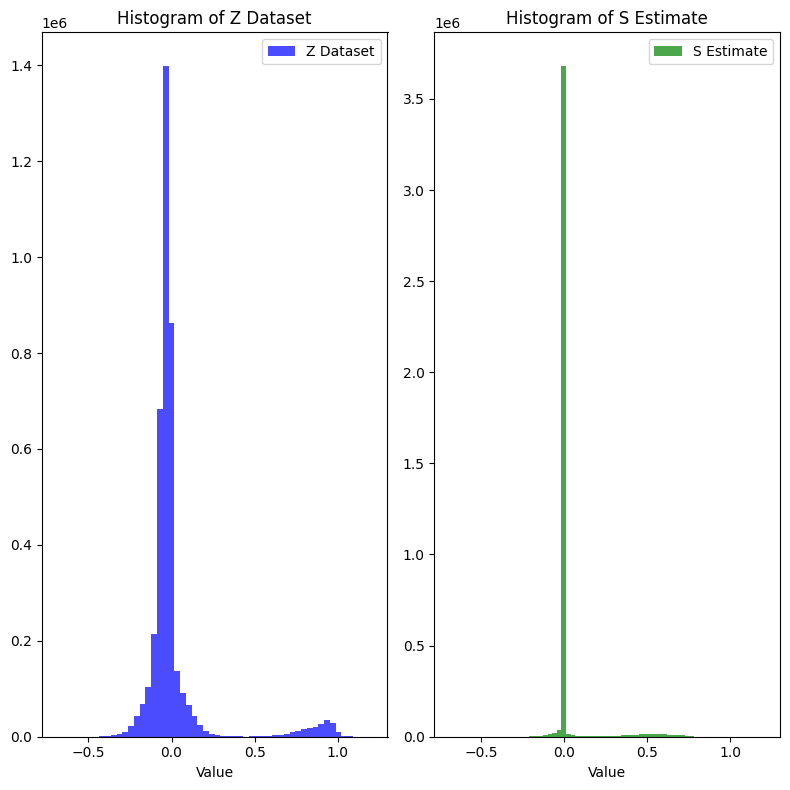

In [18]:
import torch
import matplotlib.pyplot as plt

# Load the data for Z
Z_dataset = Z_dataset_test.flatten()
S_estimate = Ss.flatten()

# Setting up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 8))  # 1 rows, 2 columns

# Histogram settings
bin_settings = 60  # Number of bins
alpha_setting = 0.7  # Transparency

# Determine combined limits for x-axis
combined_data = np.concatenate([Z_dataset, S_estimate])
x_min = combined_data.min()
x_max = combined_data.max()
xlims = (x_min, x_max)  # Define x-axis limits based on combined data

# Plot histograms
# Row for Z
axes[0].hist(Z_dataset, bins=bin_settings, alpha=alpha_setting, color='blue', label='Z Dataset')
axes[0].set_title('Histogram of Z Dataset')
axes[0].set_xlim(xlims)
axes[1].hist(S_estimate, bins=bin_settings, alpha=alpha_setting, color='green', label='S Estimate')
axes[1].set_title('Histogram of S Estimate')
axes[1].set_xlim(xlims)

for ax in axes.flat:
    ax.legend()
    ax.set_xlabel('Value')

plt.tight_layout()

plt.show(block=True)

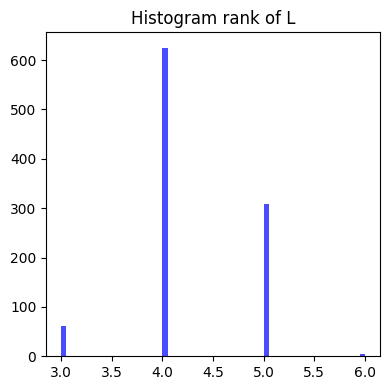

In [9]:
# Setting up the figure and axes
fig, axes = plt.subplots(1, 1, figsize=(4, 4))  # 1 rows, 2 columns

# Histogram settings
bin_settings = 60  # Number of bins
alpha_setting = 0.7  # Transparency

# Plot histograms
# Row for Z
axes.hist(rank_Ls, bins=bin_settings, alpha=alpha_setting, color='blue', label='rank_L')
axes.set_title('Histogram rank of L')


plt.tight_layout()

plt.show(block=True)


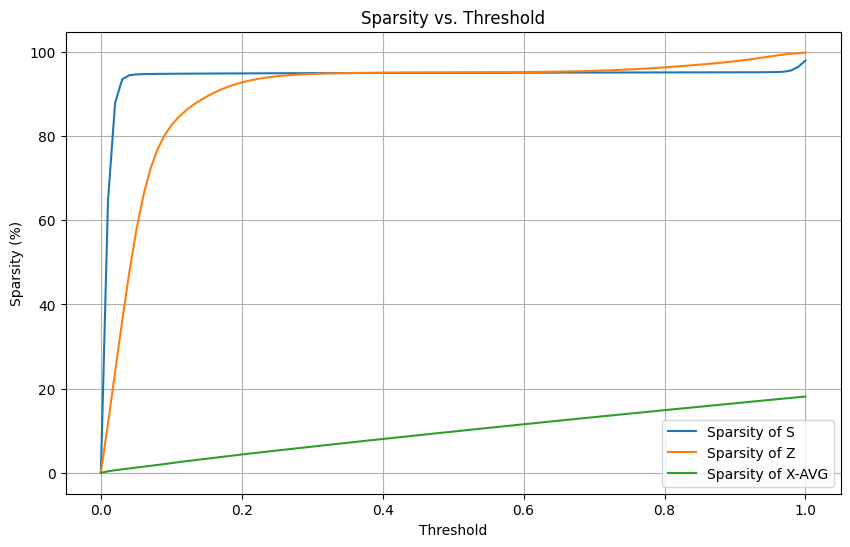

In [10]:
Ss_np = Ss
Z_np = Z_dataset_test
X_AVG_np = X_dataset_test-X_dataset_test.mean(axis=2,keepdims=True)

def calculate_sparsity(data, threshold):
    """Calculate the percentage of values in 'data' below 'threshold'."""
    return np.mean(np.abs(data) < threshold) * 100  # Percentage of values below the threshold

thresholds = np.linspace(0, 1, num=100)  # Change range and density as needed
sparsity_Ss = [calculate_sparsity(Ss_np, t) for t in thresholds]
sparsity_Z = [calculate_sparsity(Z_np, t) for t in thresholds]
sparsity_X_AVG = [calculate_sparsity(X_AVG_np, t) for t in thresholds]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, sparsity_Ss, label='Sparsity of S')
plt.plot(thresholds, sparsity_Z, label='Sparsity of Z')
plt.plot(thresholds, sparsity_X_AVG, label='Sparsity of X-AVG')
plt.xlabel('Threshold')
plt.ylabel('Sparsity (%)')
plt.title('Sparsity vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
#MSE of ||L(1)+S-X||

rank_1_Ls = np.zeros_like(Ls)  # To store the rank-1 approximations of L

for i in range(len_test):
    U, s, V = np.linalg.svd(Ls[i], full_matrices=False)
    # Ensure there is at least one non-zero singular value
    if s.size > 0:
        rank_1_Ls[i] = s[0] * np.outer(U[:, 0], V[0, :])

def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

mse_values = np.zeros((len_test,))

for i in range(len_test):
    # Reconstruct X using rank-1 L plus S
    reconstructed_X = rank_1_Ls[i] + Ss[i]
    mse_values[i] = mse(X_dataset_test[i], reconstructed_X)

# Calculate average MSE
average_mse = mse_values.mean()
print(f"Average MSE of L(1)+S and X: {average_mse}")




Average MSE of L(1)+S and X: 3.4593597820386766e-07


In [12]:
# Function to zero out all but the k largest absolute values in each sample
def keep_k_largest(matrix, k):
    # Flatten the matrix, find the k largest values in absolute terms, zero others
    flattened = matrix.flatten()
    indices = np.abs(flattened).argsort()[-k:]
    new_matrix = np.zeros_like(flattened)
    new_matrix[indices] = flattened[indices]
    return new_matrix.reshape(matrix.shape)

k=int(5/100*4000) # 5% of the total matrix
mse_values_rec_z=np.zeros((len_test,))
for i in range(len_test):
    # Reconstruct Z using k biggest values
    reconstructed_Z = keep_k_largest(Z_dataset_test[i],k)
    mse_values_rec_z[i] = mse(Z_dataset_test[i], reconstructed_Z)

average_mse = mse_values_rec_z.mean()
print(f"Average MSE of Z and Z biggest values: {average_mse}")



Average MSE of Z and Z biggest values: 0.005099293812488756


In [13]:
#MSE between Z_dataset_test and Ss

mse_values_s_z=np.zeros((len_test,))
for i in range(len_test):
    mse_values_s_z[i] = mse(Z_dataset_test[i], Ss[i])

average_mse = mse_values_s_z.mean()
print(f"Average MSE of Z and Z biggest values: {average_mse}")

Average MSE of Z and Z biggest values: 0.007024609614033381


# Generating graphs for presentation

In [45]:


len_test = 1000
rows = 400
cols = 10
sig1vt_supp=10
zt_noise_sigma=0.01

data = OD.Data(rows=rows, cols=cols, sig1vt_supp=sig1vt_supp, k_sparse=5,zt_noise_sigma=zt_noise_sigma)
X_dataset_test, C_dataset_test, Z_dataset_test = data.create_Dataset(len_test)

x_avg=X_dataset_test.mean(axis=2,keepdims=True)
x_minus_xavg=X_dataset_test-x_avg


Ss=np.zeros((len_test,rows,cols))
Ls=np.zeros((len_test,rows,cols))
S_tilde=np.zeros((len_test,rows,cols))
rank_Ls=np.zeros((len_test,1))

for i in range (len_test):
    L,S=robust_pca(X_dataset_test[i,:,:],max_iter=1000)
    Ss[i,:,:]=S
    Ls[i,:,:]=L
    U, s, V = np.linalg.svd(L)


# Load the data for Z
Z_dataset = Z_dataset_test.flatten()
S_estimate = Ss.flatten()
x_minus_xavg_flatten=x_minus_xavg.flatten()
X_dataset_test_flatten=X_dataset_test.flatten()

# Setting up the figure and axes
fig, axes = plt.subplots(1, 4, figsize=(4, 16))  # 1 rows, 2 columns

# Histogram settings
bin_settings = 200  # Number of bins
alpha_setting = 0.7  # Transparency

# Determine combined limits for x-axis
combined_data = np.concatenate([Z_dataset, S_estimate])
x_min = combined_data.min()
x_max = combined_data.max()
xlims = (x_min, x_max)  # Define x-axis limits based on combined data

# Plot histograms
# Row for Z
axes[0].hist(X_dataset_test_flatten, bins=bin_settings, alpha=alpha_setting, color='blue', label='X')
axes[0].set_title('Histogram of X Dataset')
axes[0].set_xlim(xlims)
axes[1].hist(x_minus_xavg_flatten, bins=bin_settings, alpha=alpha_setting, color='orange', label='X-X_avg ')
axes[1].set_title('Histogram of X-X_avg')
axes[1].set_xlim(xlims)
axes[2].hist(Z_dataset, bins=bin_settings, alpha=alpha_setting, color='magenta', label='Z')
axes[2].set_title('Histogram of Z')
axes[2].set_xlim(xlims)
axes[3].hist(S_estimate, bins=bin_settings, alpha=alpha_setting, color='green', label='S')
axes[3].set_title('Histogram of S')
axes[3].set_xlim(xlims)


for ax in axes.flat:
    ax.legend()
    ax.set_xlabel('Value')

plt.tight_layout()

plt.show(block=True)

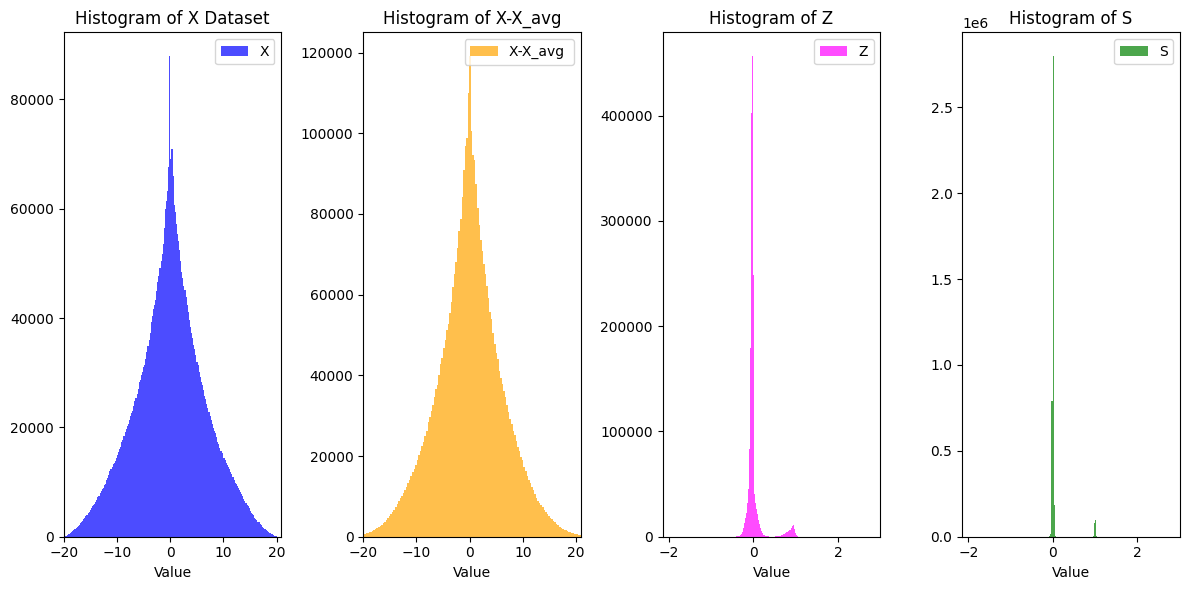

In [40]:

# Setting up the figure and axes
fig, axes = plt.subplots(1, 4, figsize=(12, 6))  # 1 rows, 2 columns

# Histogram settings
bin_settings = 200  # Number of bins
alpha_setting = 0.7  # Transparency

# Determine combined limits for x-axis
combined_data = np.concatenate([Z_dataset, S_estimate])
x_min = combined_data.min()
x_max = combined_data.max()

x_min_x = X_dataset_test_flatten.min()
x_max_x = X_dataset_test_flatten.max()
xlims = (x_min, x_max)  # Define x-axis limits based on combined data
xlims_x = (x_min_x, x_max_x)  # Define x-axis limits based on combined data

# Plot histograms
# Row for Z
axes[0].hist(X_dataset_test_flatten, bins=bin_settings, alpha=alpha_setting, color='blue', label='X')
axes[0].set_title('Histogram of X Dataset')
axes[0].set_xlim(xlims_x)
axes[1].hist(x_minus_xavg_flatten, bins=bin_settings, alpha=alpha_setting, color='orange', label='X-X_avg ')
axes[1].set_title('Histogram of X-X_avg')
axes[1].set_xlim(xlims_x)
axes[2].hist(Z_dataset, bins=bin_settings, alpha=alpha_setting, color='magenta', label='Z')
axes[2].set_title('Histogram of Z')
axes[2].set_xlim(xlims)
axes[3].hist(S_estimate, bins=bin_settings, alpha=alpha_setting, color='green', label='S')
axes[3].set_title('Histogram of S')
axes[3].set_xlim(xlims)

for ax in axes.flat:
    ax.legend()
    ax.set_xlabel('Value')

plt.tight_layout()

plt.show(block=True)


In [46]:

for i in range (len_test):
    L,S=robust_pca(X_dataset_test[i,:,:],max_iter=1)
    Ss[i,:,:]=S
    Ls[i,:,:]=L
    U, s, V = np.linalg.svd(L)
    L1=s[0]*np.outer(U[:, 0], V[0, :])
    S_tilde[i,:,:]=X_dataset_test[i,:,:]-L1;
S_1 = Ss.flatten()
S_tilde_1 = S_tilde.flatten()
for i in range (len_test):
    L,S=robust_pca(X_dataset_test[i,:,:],max_iter=3)
    Ss[i,:,:]=S
    Ls[i,:,:]=L
    U, s, V = np.linalg.svd(L)
    L1=s[0]*np.outer(U[:, 0], V[0, :])
    S_tilde[i,:,:]=X_dataset_test[i,:,:]-L1;
S_3 = Ss.flatten()
S_tilde_3 = S_tilde.flatten()
for i in range (len_test):
    L,S=robust_pca(X_dataset_test[i,:,:],max_iter=5)
    Ss[i,:,:]=S
    Ls[i,:,:]=L
    U, s, V = np.linalg.svd(L)
    L1=s[0]*np.outer(U[:, 0], V[0, :])
    S_tilde[i,:,:]=X_dataset_test[i,:,:]-L1;
S_5 = Ss.flatten()
S_tilde_5 = S_tilde.flatten()
for i in range (len_test):
    L,S=robust_pca(X_dataset_test[i,:,:],max_iter=20)
    Ss[i,:,:]=S
    Ls[i,:,:]=L
    U, s, V = np.linalg.svd(L)
    L1=s[0]*np.outer(U[:, 0], V[0, :])
    S_tilde[i,:,:]=X_dataset_test[i,:,:]-L1;
S_20 = Ss.flatten()
S_tilde_20 = S_tilde.flatten()
for i in range (len_test):
    L,S=robust_pca(X_dataset_test[i,:,:],max_iter=1000)
    Ss[i,:,:]=S
    Ls[i,:,:]=L
    U, s, V = np.linalg.svd(L)
    L1=s[0]*np.outer(U[:, 0], V[0, :])
    S_tilde[i,:,:]=X_dataset_test[i,:,:]-L1;
S_1000 = Ss.flatten()
S_tilde_1000 = S_tilde.flatten()





(-2.146358485687335, 3.0055554133424316)

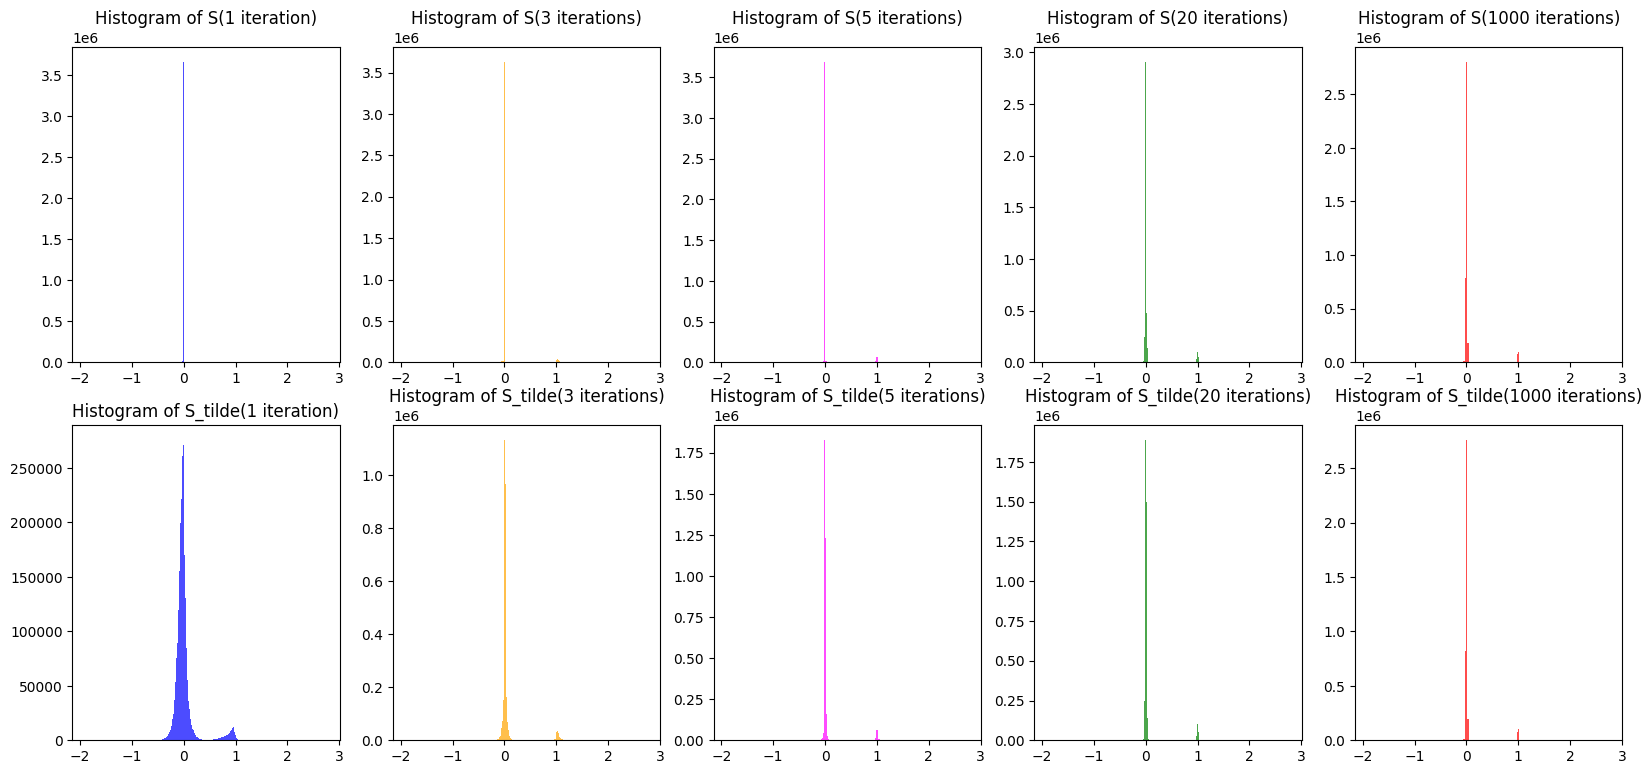

In [56]:

# Setting up the figure and axes
fig, axes = plt.subplots(2, 5, figsize=(20, 9))  # 1 rows, 2 columns

# Histogram settings
bin_settings = 200  # Number of bins
alpha_setting = 0.7  # Transparency

# Plot histograms
# Row for Z
axes[0][0].hist(S_1, bins=bin_settings, alpha=alpha_setting, color='blue', label='1 iteration')
axes[0][0].set_title('Histogram of S(1 iteration)')
axes[0][0].set_xlim(xlims)
axes[0][1].hist(S_3, bins=bin_settings, alpha=alpha_setting, color='orange', label='3 iterations')
axes[0][1].set_title('Histogram of S(3 iterations)')
axes[0][1].set_xlim(xlims)
axes[0][2].hist(S_5, bins=bin_settings, alpha=alpha_setting, color='magenta', label='5 iterations')
axes[0][2].set_title('Histogram of S(5 iterations)')
axes[0][2].set_xlim(xlims)
axes[0][3].hist(S_20, bins=bin_settings, alpha=alpha_setting, color='green', label='20 iterations')
axes[0][3].set_title('Histogram of S(20 iterations)')
axes[0][3].set_xlim(xlims)
axes[0][4].hist(S_1000, bins=bin_settings, alpha=alpha_setting, color='red', label='20 iterations')
axes[0][4].set_title('Histogram of S(1000 iterations)')
axes[0][4].set_xlim(xlims)

axes[1][0].hist(S_tilde_1, bins=bin_settings, alpha=alpha_setting, color='blue', label='1 iteration')
axes[1][0].set_title('Histogram of S_tilde(1 iteration)')
axes[1][0].set_xlim(xlims)
axes[1][1].hist(S_tilde_3, bins=bin_settings, alpha=alpha_setting, color='orange', label='3 iterations')
axes[1][1].set_title('Histogram of S_tilde(3 iterations)')
axes[1][1].set_xlim(xlims)
axes[1][2].hist(S_tilde_5, bins=bin_settings, alpha=alpha_setting, color='magenta', label='5 iterations')
axes[1][2].set_title('Histogram of S_tilde(5 iterations)')
axes[1][2].set_xlim(xlims)
axes[1][3].hist(S_tilde_20, bins=bin_settings, alpha=alpha_setting, color='green', label='20 iterations')
axes[1][3].set_title('Histogram of S_tilde(20 iterations)')
axes[1][3].set_xlim(xlims)
axes[1][4].hist(S_tilde_1000, bins=bin_settings, alpha=alpha_setting, color='red', label='20 iterations')
axes[1][4].set_title('Histogram of S_tilde(1000 iterations)')
axes[1][4].set_xlim(xlims)



In [58]:

def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()
MSE_S_1_S_1_tilde=mse(S_1,S_tilde_1)/mse(X_dataset_test_flatten,0)
MSE_S_3_S_3_tilde=mse(S_3,S_tilde_3)/mse(X_dataset_test_flatten,0)
MSE_S_5_S_5_tilde=mse(S_5,S_tilde_5)/mse(X_dataset_test_flatten,0)
MSE_S_20_S_20_tilde=mse(S_20,S_tilde_20)/mse(X_dataset_test_flatten,0)
MSE_S_1000_S_1000_tilde=mse(S_1000,S_tilde_1000)/mse(X_dataset_test_flatten,0)
print(f"MSE of S and S_tilde(1 iteration): {MSE_S_1_S_1_tilde}")
print(f"MSE of S and S_tilde(3 iterations): {MSE_S_3_S_3_tilde}")
print(f"MSE of S and S_tilde(5 iterations): {MSE_S_5_S_5_tilde}")
print(f"MSE of S and S_tilde(20 iterations): {MSE_S_20_S_20_tilde}")
print(f"MSE of S and S_tilde(1000 iterations): {MSE_S_1000_S_1000_tilde}")

MSE of S and S_tilde(1 iteration): 0.00031627185493682323
MSE of S and S_tilde(3 iterations): 1.5246809088848868e-05
MSE of S and S_tilde(5 iterations): 3.069832590331388e-06
MSE of S and S_tilde(20 iterations): 3.407848574552061e-07
MSE of S and S_tilde(1000 iterations): 8.259396651718985e-09
